<a href="https://colab.research.google.com/github/open-mmlab/mmsegmentation/blob/master/demo/MMSegmentation_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Mon_May__3_19:15:13_PDT_2021
Cuda compilation tools, release 11.3, V11.3.109
Build cuda_11.3.r11.3/compiler.29920130_0
gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



# Import Libraries

In [2]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.10.0 True
0.21.1


# Visualize the dataset

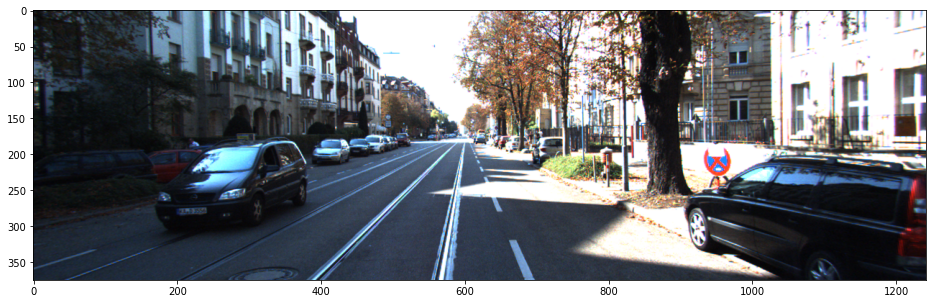

In [3]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('KITTI/images/000000_10.png')
plt.figure(figsize=(16, 14))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [4]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = 'KITTI'
img_dir = 'images'
ann_dir = 'labels'
# define class and plaette for better visualization
classes = ('background', 'road', 'sidewalk', 'building','wall', 'fence', 'pole', 'traffic light', 'traffic sign',
          'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck', 'bus','train','motorcycle','bicycle')
palette = [[0,0,0], [128, 64, 128], [244,35,232], [70,70,70], [102,102,156], [190,153,153], [153, 153, 153],
           [250, 170,30], [220, 220, 0], [107, 142, 35], [152,251,152], [70,130,180],[220,20,60],[255,0,0],
           [0,0,142], [0,0,70], [0,60,100], [0,80,100],[0,0,230],[119,11,32]]
print(len(classes))
print(len(palette))
'''
for file in mmcv.scandir(osp.join(data_root, ann_dir)):
  seg_img = Image.open(osp.join(data_root, ann_dir, file)).convert('P')
  seg_img.putpalette(np.array(palette, dtype=np.uint8))
  seg_img.save(osp.join(data_root, ann_dir, file))
'''

20
20


"\nfor file in mmcv.scandir(osp.join(data_root, ann_dir)):\n  seg_img = Image.open(osp.join(data_root, ann_dir, file)).convert('P')\n  seg_img.putpalette(np.array(palette, dtype=np.uint8))\n  seg_img.save(osp.join(data_root, ann_dir, file))\n"

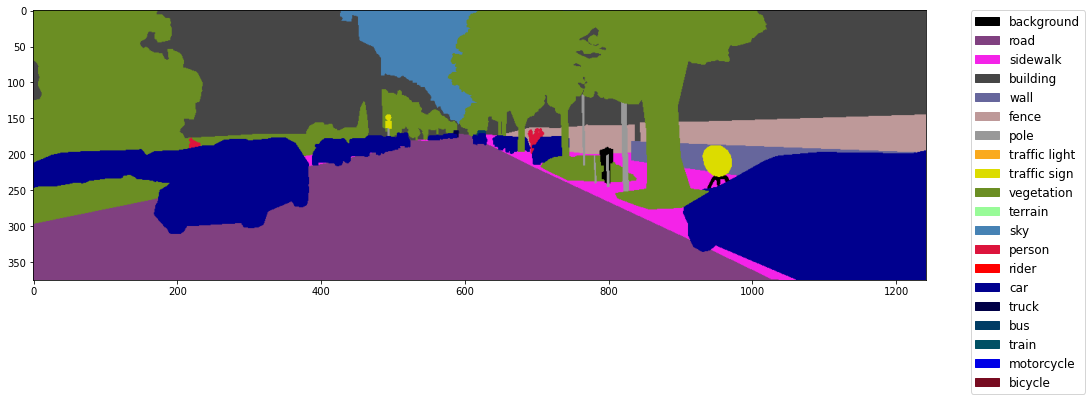

In [5]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('KITTI/labels/000000_10.png')
plt.figure(figsize=(16, 14))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(20)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

# Split Train-Val

In [6]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 6/10 as train set
  train_length = int(len(filename_list)*6/10)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 4/10 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

# Register the custom dataset

In [7]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class KittiDataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

    

# Create a config file

In [21]:
from mmcv import Config
cfg = Config.fromfile('../configs/segmenter/segmenter_vit-t_mask_8x1_512x512_160k_ade20k.py')

In [22]:
from mmseg.apis import set_random_seed

#HYPERPARAMETERS TO TUNE : Learning rate, batch size, optimizer, dropout

#OTHER BACKBONES TO TRY: ViT-Base, ViT-Large, Swin Transformer

#THINGS TO TRY: other data augmentations, k-fold cross validation, Tensorboard, Pretrain on Cityscapes

#MAIN PROBLEM: class imbalance -> validation data has few to no examples of some classes -> val. accuracy ~ 0

# add CLASSES and PALETTE to checkpoint
cfg.checkpoint_config.meta = dict(
    CLASSES=classes,
    PALETTE=palette)

# Since we use ony one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='LN', requires_grad=True)
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 20

# Modify dataset type and path
cfg.dataset_type = 'KittiDataset'
cfg.data_root = data_root

#Batch size
cfg.data.samples_per_gpu = 8
cfg.data.workers_per_gpu=8

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (414, 375)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1242, 375), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1242, 375),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = 'splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = 'splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = 'splits/val.txt'

#cfg.load_from = 'checkpoints/vit_tiny_p16_384.pth'
cfg.load_from = './saved_models/segmenter1/latest.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './saved_models/segmenter1'

cfg.runner.max_iters = 10000
cfg.log_config.interval = 100
cfg.evaluation.interval = 500
cfg.checkpoint_config.interval = 1000

# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
backbone_norm_cfg = dict(type='LN', eps=1e-06, requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='pretrain/vit_tiny_p16_384.pth',
    backbone=dict(
        type='VisionTransformer',
        img_size=(512, 512),
        patch_size=16,
        in_channels=3,
        embed_dims=192,
        num_layers=12,
        num_heads=3,
        drop_path_rate=0.1,
        attn_drop_rate=0.0,
        drop_rate=0.0,
        final_norm=True,
        norm_cfg=dict(type='LN', requires_grad=True),
        with_cls_token=True,
        interpolate_mode='bicubic'),
    decode_head=dict(
        type='SegmenterMaskTransformerHead',
        in_channels=192,
        channels=192,
        num_classes=20,
        num_layers=2,
        num_heads=3,
        embed_dims=192,
        dropout_ratio=0.0,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0),
        norm_cfg=dict(type='LN', requires_grad=True)),
    test_cfg=dict(mode='slide

# Train and Evaluation

In [23]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-02-14 22:49:46,210 - mmseg - INFO - Loaded 120 images
2022-02-14 22:49:46,290 - mmseg - INFO - Loaded 80 images
2022-02-14 22:49:46,290 - mmseg - INFO - load checkpoint from local path: ./saved_models/segmenter1/latest.pth
2022-02-14 22:49:46,331 - mmseg - INFO - Start running, host: rahul@rahul-Blade, work_dir: /home/rahul/Desktop/mmsegmentation/transformers/saved_models/segmenter1
2022-02-14 22:49:46,332 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) P

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.5 task/s, elapsed: 6s, ETA:     0s

2022-02-14 22:54:02,049 - mmseg - INFO - per class results:
2022-02-14 22:54:02,052 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  |  4.2  |  4.69 |
|      road     | 72.69 | 84.59 |
|    sidewalk   | 22.67 | 34.07 |
|    building   | 43.44 | 66.43 |
|      wall     |  2.09 |  2.25 |
|     fence     |  0.0  |  0.0  |
|      pole     | 12.18 | 15.73 |
| traffic light |  0.0  |  0.0  |
|  traffic sign |  0.0  |  0.0  |
|   vegetation  | 67.57 | 88.53 |
|    terrain    | 46.77 | 69.36 |
|      sky      | 80.74 | 92.86 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 34.62 | 47.76 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-14 22:54:02,053 - mmseg - INFO - Summary:
2022-02-14 22:54:02,053 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.8 task/s, elapsed: 6s, ETA:     0s

2022-02-14 22:58:17,417 - mmseg - INFO - per class results:
2022-02-14 22:58:17,419 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  |  2.42 |  2.52 |
|      road     | 71.56 | 86.07 |
|    sidewalk   | 20.12 | 32.53 |
|    building   | 45.82 | 74.31 |
|      wall     |  4.3  |  4.72 |
|     fence     |  0.0  |  0.0  |
|      pole     | 12.12 | 15.03 |
| traffic light |  0.0  |  0.0  |
|  traffic sign |  0.0  |  0.0  |
|   vegetation  | 68.97 | 86.97 |
|    terrain    | 52.45 | 62.92 |
|      sky      | 83.04 | 91.45 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 37.65 | 65.62 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-14 22:58:17,420 - mmseg - INFO - Summary:
2022-02-14 22:58:17,420 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.4 task/s, elapsed: 6s, ETA:     0s

2022-02-14 23:02:34,466 - mmseg - INFO - per class results:
2022-02-14 23:02:34,468 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  |  4.09 |  4.46 |
|      road     | 72.05 | 89.59 |
|    sidewalk   | 15.91 | 20.27 |
|    building   | 38.02 | 47.16 |
|      wall     |  4.91 |  5.65 |
|     fence     |  0.0  |  0.0  |
|      pole     | 11.63 | 15.19 |
| traffic light |  0.0  |  0.0  |
|  traffic sign |  0.0  |  0.0  |
|   vegetation  | 68.84 | 90.22 |
|    terrain    | 52.37 | 73.92 |
|      sky      | 81.78 | 93.96 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 35.12 | 52.61 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-14 23:02:34,468 - mmseg - INFO - Summary:
2022-02-14 23:02:34,469 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.7 task/s, elapsed: 6s, ETA:     0s

2022-02-14 23:06:52,762 - mmseg - INFO - per class results:
2022-02-14 23:06:52,764 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  |  4.94 |  5.3  |
|      road     | 71.81 | 89.73 |
|    sidewalk   |  17.0 | 22.05 |
|    building   | 46.88 | 61.12 |
|      wall     |  5.0  |  5.42 |
|     fence     |  0.0  |  0.0  |
|      pole     |  9.95 | 11.96 |
| traffic light |  0.0  |  0.0  |
|  traffic sign |  0.0  |  0.0  |
|   vegetation  |  70.5 | 92.61 |
|    terrain    | 53.87 | 68.87 |
|      sky      | 80.31 | 93.97 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 41.32 | 56.21 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-14 23:06:52,765 - mmseg - INFO - Summary:
2022-02-14 23:06:52,766 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.8 task/s, elapsed: 6s, ETA:     0s

2022-02-14 23:11:08,062 - mmseg - INFO - per class results:
2022-02-14 23:11:08,064 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  |  3.54 |  3.68 |
|      road     | 73.62 | 88.99 |
|    sidewalk   | 18.96 | 23.32 |
|    building   | 47.97 | 62.53 |
|      wall     |  3.79 |  4.12 |
|     fence     |  0.0  |  0.0  |
|      pole     | 11.88 | 15.01 |
| traffic light |  0.0  |  0.0  |
|  traffic sign |  0.0  |  0.0  |
|   vegetation  | 70.45 |  92.3 |
|    terrain    | 52.98 | 65.16 |
|      sky      | 82.25 | 92.12 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 42.28 | 70.23 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-14 23:11:08,065 - mmseg - INFO - Summary:
2022-02-14 23:11:08,066 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.9 task/s, elapsed: 6s, ETA:     0s

2022-02-14 23:15:23,328 - mmseg - INFO - per class results:
2022-02-14 23:15:23,330 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  |  6.03 |  6.7  |
|      road     | 74.29 | 85.74 |
|    sidewalk   | 17.98 | 21.89 |
|    building   | 47.61 | 72.62 |
|      wall     |  1.61 |  1.87 |
|     fence     |  0.0  |  0.0  |
|      pole     |  9.71 | 11.13 |
| traffic light |  0.0  |  0.0  |
|  traffic sign |  0.0  |  0.0  |
|   vegetation  | 72.51 | 90.13 |
|    terrain    | 54.83 | 76.17 |
|      sky      | 83.17 | 93.09 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 41.24 | 67.92 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-14 23:15:23,331 - mmseg - INFO - Summary:
2022-02-14 23:15:23,332 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.6 task/s, elapsed: 6s, ETA:     0s

2022-02-14 23:19:41,126 - mmseg - INFO - per class results:
2022-02-14 23:19:41,128 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  |  5.22 |  5.58 |
|      road     | 72.87 | 90.24 |
|    sidewalk   | 18.39 |  22.9 |
|    building   | 46.74 | 61.73 |
|      wall     |  5.37 |  6.28 |
|     fence     |  0.0  |  0.0  |
|      pole     | 10.99 | 13.41 |
| traffic light |  2.76 |  2.77 |
|  traffic sign |  0.0  |  0.0  |
|   vegetation  | 71.53 | 90.47 |
|    terrain    | 54.27 | 70.09 |
|      sky      |  83.9 | 91.79 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 41.74 |  69.2 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-14 23:19:41,128 - mmseg - INFO - Summary:
2022-02-14 23:19:41,129 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.8 task/s, elapsed: 6s, ETA:     0s

2022-02-14 23:23:56,744 - mmseg - INFO - per class results:
2022-02-14 23:23:56,746 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  |  6.96 |  7.88 |
|      road     | 73.33 | 89.07 |
|    sidewalk   |  17.1 | 20.82 |
|    building   | 48.33 | 69.65 |
|      wall     |  4.57 |  5.3  |
|     fence     |  0.0  |  0.0  |
|      pole     | 12.86 | 16.82 |
| traffic light |  1.02 |  1.02 |
|  traffic sign |  0.0  |  0.0  |
|   vegetation  | 72.32 | 90.58 |
|    terrain    |  56.3 | 71.19 |
|      sky      | 83.51 | 92.91 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 42.71 | 67.47 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-14 23:23:56,746 - mmseg - INFO - Summary:
2022-02-14 23:23:56,748 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.7 task/s, elapsed: 6s, ETA:     0s

2022-02-14 23:28:12,241 - mmseg - INFO - per class results:
2022-02-14 23:28:12,242 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  |  10.6 | 12.62 |
|      road     | 73.86 | 89.28 |
|    sidewalk   | 20.47 | 25.46 |
|    building   | 49.79 | 72.51 |
|      wall     |  2.56 |  2.74 |
|     fence     |  0.0  |  0.0  |
|      pole     | 11.89 |  14.7 |
| traffic light |  4.24 |  4.26 |
|  traffic sign |  0.04 |  0.04 |
|   vegetation  | 71.54 | 91.65 |
|    terrain    | 54.32 | 69.34 |
|      sky      | 83.79 | 92.27 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 42.69 | 60.12 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-14 23:28:12,243 - mmseg - INFO - Summary:
2022-02-14 23:28:12,243 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.9 task/s, elapsed: 6s, ETA:     0s

2022-02-14 23:32:33,752 - mmseg - INFO - per class results:
2022-02-14 23:32:33,753 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  |  6.97 |  7.74 |
|      road     | 73.97 | 89.57 |
|    sidewalk   |  24.4 | 35.42 |
|    building   | 48.78 | 71.98 |
|      wall     |  4.73 |  5.54 |
|     fence     |  0.0  |  0.0  |
|      pole     | 13.06 | 17.15 |
| traffic light |  0.73 |  0.73 |
|  traffic sign |  0.0  |  0.0  |
|   vegetation  | 72.46 | 91.02 |
|    terrain    | 55.24 | 69.42 |
|      sky      | 83.85 | 91.53 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 43.97 | 62.95 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-14 23:32:33,754 - mmseg - INFO - Summary:
2022-02-14 23:32:33,755 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.7 task/s, elapsed: 6s, ETA:     0s

2022-02-14 23:36:51,572 - mmseg - INFO - per class results:
2022-02-14 23:36:51,573 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  |  6.73 |  7.31 |
|      road     | 74.02 | 91.12 |
|    sidewalk   | 15.88 |  18.1 |
|    building   |  48.0 | 64.42 |
|      wall     |  5.4  |  6.01 |
|     fence     |  0.0  |  0.0  |
|      pole     | 12.65 | 15.77 |
| traffic light |  3.45 |  3.47 |
|  traffic sign |  0.01 |  0.01 |
|   vegetation  | 72.48 | 91.12 |
|    terrain    | 52.35 | 68.74 |
|      sky      | 84.45 | 92.98 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 42.91 | 69.72 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-14 23:36:51,574 - mmseg - INFO - Summary:
2022-02-14 23:36:51,574 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.3 task/s, elapsed: 7s, ETA:     0s

2022-02-14 23:41:13,051 - mmseg - INFO - per class results:
2022-02-14 23:41:13,053 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  | 12.42 | 15.16 |
|      road     | 75.07 | 89.16 |
|    sidewalk   | 18.91 | 21.87 |
|    building   |  50.1 | 69.83 |
|      wall     |  4.51 |  4.98 |
|     fence     |  0.0  |  0.0  |
|      pole     | 11.62 | 14.02 |
| traffic light |  2.48 |  2.48 |
|  traffic sign |  0.02 |  0.02 |
|   vegetation  | 73.39 | 91.16 |
|    terrain    | 57.18 | 74.29 |
|      sky      | 83.56 |  91.3 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 44.01 | 70.88 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-14 23:41:13,053 - mmseg - INFO - Summary:
2022-02-14 23:41:13,054 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.7 task/s, elapsed: 6s, ETA:     0s

2022-02-14 23:45:30,897 - mmseg - INFO - per class results:
2022-02-14 23:45:30,900 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  | 10.83 | 12.97 |
|      road     | 74.59 | 89.42 |
|    sidewalk   | 22.18 | 27.42 |
|    building   | 48.84 | 65.32 |
|      wall     |  5.32 |  6.26 |
|     fence     |  0.0  |  0.0  |
|      pole     | 14.48 | 19.37 |
| traffic light |  6.97 |  7.16 |
|  traffic sign |  0.15 |  0.15 |
|   vegetation  |  72.5 | 89.94 |
|    terrain    | 57.64 | 73.64 |
|      sky      | 83.92 | 91.93 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 43.22 | 71.55 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-14 23:45:30,901 - mmseg - INFO - Summary:
2022-02-14 23:45:30,901 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.7 task/s, elapsed: 6s, ETA:     0s

2022-02-14 23:49:46,369 - mmseg - INFO - per class results:
2022-02-14 23:49:46,371 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  | 11.25 | 13.35 |
|      road     | 75.16 | 88.87 |
|    sidewalk   | 23.01 | 29.72 |
|    building   | 49.12 | 68.02 |
|      wall     |  3.57 |  3.73 |
|     fence     |  0.0  |  0.0  |
|      pole     | 13.57 | 17.54 |
| traffic light |  9.74 |  9.94 |
|  traffic sign |  0.03 |  0.03 |
|   vegetation  | 72.44 | 91.97 |
|    terrain    | 55.07 | 68.49 |
|      sky      | 83.54 | 92.32 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 45.18 | 69.89 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-14 23:49:46,372 - mmseg - INFO - Summary:
2022-02-14 23:49:46,372 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.9 task/s, elapsed: 6s, ETA:     0s

2022-02-14 23:54:01,405 - mmseg - INFO - per class results:
2022-02-14 23:54:01,407 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  |  9.56 | 10.63 |
|      road     | 74.21 | 89.46 |
|    sidewalk   | 16.91 |  18.7 |
|    building   | 48.47 | 63.01 |
|      wall     |  5.1  |  5.84 |
|     fence     |  0.0  |  0.0  |
|      pole     |  12.4 | 15.46 |
| traffic light |  4.58 |  4.61 |
|  traffic sign |  0.01 |  0.01 |
|   vegetation  | 72.71 | 91.13 |
|    terrain    | 57.95 |  73.1 |
|      sky      | 83.39 | 93.13 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 43.48 | 75.37 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-14 23:54:01,407 - mmseg - INFO - Summary:
2022-02-14 23:54:01,408 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.8 task/s, elapsed: 6s, ETA:     0s

2022-02-14 23:58:18,774 - mmseg - INFO - per class results:
2022-02-14 23:58:18,776 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  | 12.47 | 15.38 |
|      road     | 74.89 | 88.86 |
|    sidewalk   |  21.9 | 27.46 |
|    building   | 48.48 | 67.99 |
|      wall     |  5.22 |  5.74 |
|     fence     |  0.0  |  0.0  |
|      pole     | 12.21 | 15.25 |
| traffic light |  6.4  |  6.43 |
|  traffic sign |  0.03 |  0.03 |
|   vegetation  | 71.43 | 92.71 |
|    terrain    | 56.54 | 70.74 |
|      sky      | 83.67 | 92.36 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 45.27 |  62.3 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-14 23:58:18,778 - mmseg - INFO - Summary:
2022-02-14 23:58:18,778 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.9 task/s, elapsed: 6s, ETA:     0s

2022-02-15 00:02:33,957 - mmseg - INFO - per class results:
2022-02-15 00:02:33,959 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  | 12.51 | 14.55 |
|      road     | 74.03 | 89.44 |
|    sidewalk   | 23.34 | 34.58 |
|    building   | 49.52 | 72.82 |
|      wall     |  5.68 |  6.64 |
|     fence     |  0.0  |  0.0  |
|      pole     | 14.02 | 18.48 |
| traffic light | 10.99 | 11.15 |
|  traffic sign |  0.08 |  0.08 |
|   vegetation  | 73.38 | 90.26 |
|    terrain    | 55.32 | 74.92 |
|      sky      | 83.85 | 92.74 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 44.61 | 57.81 |
|     truck     |  0.02 |  0.02 |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-15 00:02:33,960 - mmseg - INFO - Summary:
2022-02-15 00:02:33,961 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 13.0 task/s, elapsed: 6s, ETA:     0s

2022-02-15 00:06:51,328 - mmseg - INFO - per class results:
2022-02-15 00:06:51,330 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  | 12.94 | 15.66 |
|      road     | 74.49 |  89.7 |
|    sidewalk   |  20.8 | 26.13 |
|    building   | 50.36 | 67.92 |
|      wall     |  5.37 |  6.08 |
|     fence     |  0.0  |  0.0  |
|      pole     | 13.33 | 17.55 |
| traffic light | 11.78 | 11.95 |
|  traffic sign |  0.08 |  0.08 |
|   vegetation  | 73.23 | 90.74 |
|    terrain    | 56.72 | 77.34 |
|      sky      | 83.66 | 93.58 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 46.21 | 64.24 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-15 00:06:51,330 - mmseg - INFO - Summary:
2022-02-15 00:06:51,331 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.7 task/s, elapsed: 6s, ETA:     0s

2022-02-15 00:11:12,757 - mmseg - INFO - per class results:
2022-02-15 00:11:12,758 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  | 15.07 | 18.62 |
|      road     | 74.84 |  90.5 |
|    sidewalk   | 22.01 | 26.52 |
|    building   | 49.97 | 68.84 |
|      wall     |  5.6  |  6.07 |
|     fence     |  0.0  |  0.0  |
|      pole     | 14.11 |  18.6 |
| traffic light | 10.14 | 10.35 |
|  traffic sign |  0.26 |  0.26 |
|   vegetation  | 73.73 | 90.72 |
|    terrain    | 57.62 | 74.15 |
|      sky      | 83.86 |  92.9 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 45.59 | 67.75 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-15 00:11:12,759 - mmseg - INFO - Summary:
2022-02-15 00:11:12,759 - mmseg 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 80/80, 12.6 task/s, elapsed: 6s, ETA:     0s

2022-02-15 00:15:32,895 - mmseg - INFO - per class results:
2022-02-15 00:15:32,897 - mmseg - INFO - 
+---------------+-------+-------+
|     Class     |  IoU  |  Acc  |
+---------------+-------+-------+
|   background  | 14.65 | 18.15 |
|      road     | 74.72 | 90.99 |
|    sidewalk   | 20.06 | 24.77 |
|    building   |  51.0 | 68.73 |
|      wall     |  5.78 |  6.5  |
|     fence     |  0.0  |  0.0  |
|      pole     |  14.0 |  18.3 |
| traffic light | 13.25 |  13.7 |
|  traffic sign |  0.17 |  0.17 |
|   vegetation  | 73.15 | 90.98 |
|    terrain    | 59.04 | 71.61 |
|      sky      | 84.98 | 92.51 |
|     person    |  0.0  |  0.0  |
|     rider     |  0.0  |  0.0  |
|      car      | 45.99 | 70.43 |
|     truck     |  0.0  |  0.0  |
|      bus      |  0.0  |  0.0  |
|     train     |  0.0  |  0.0  |
|   motorcycle  |  0.0  |  0.0  |
|    bicycle    |  0.0  |  0.0  |
+---------------+-------+-------+
2022-02-15 00:15:32,897 - mmseg - INFO - Summary:
2022-02-15 00:15:32,898 - mmseg 

# Inference

<Figure size 576x432 with 0 Axes>

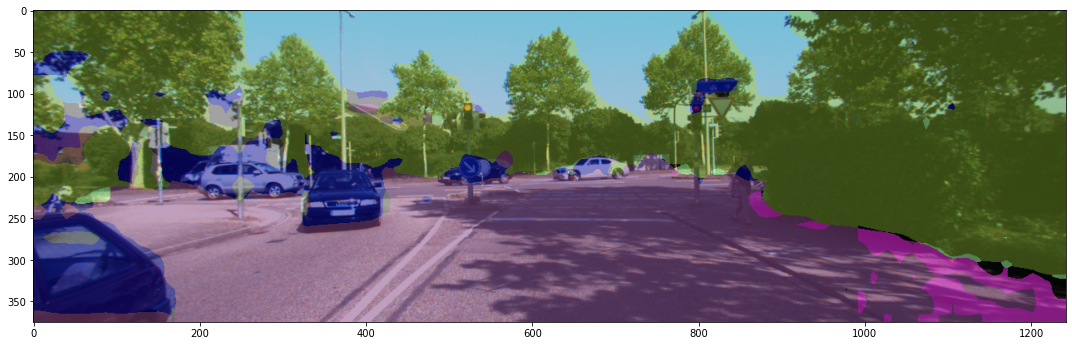

In [24]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

img = mmcv.imread('KITTI/images/000008_10.png')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

# Load a saved model for inference

load checkpoint from local path: ./saved_models/segmenter1/latest.pth


<Figure size 576x432 with 0 Axes>

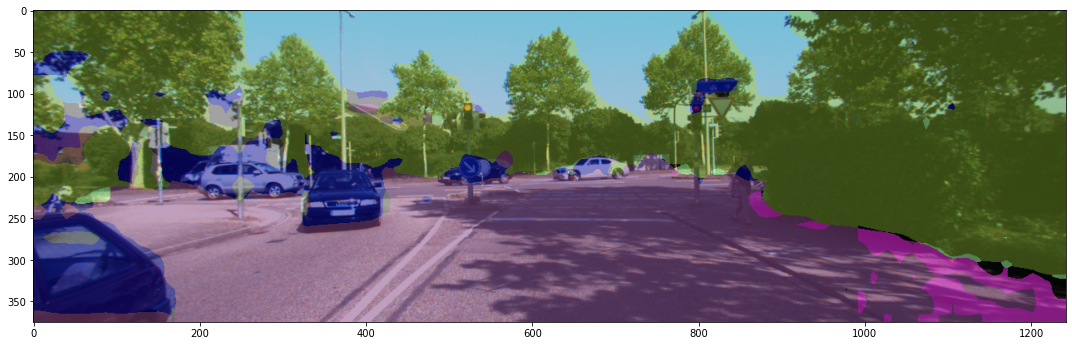

In [25]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette
import mmcv
import matplotlib.pyplot as plt

# Specify the path to model config and checkpoint file
checkpoint_file = './saved_models/segmenter1/latest.pth'

# build the model from a config file and a checkpoint file
model = init_segmentor(cfg, checkpoint_file, device='cuda:0')

img = mmcv.imread('KITTI/images/000008_10.png')
model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)